In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from xgboost import XGBClassifier

sns.set(style="whitegrid", font_scale=1.1)

RANDOM_STATE = 42
BASE = Path(".").resolve()


In [3]:
data_path = BASE / "data" / "processed" / "creditcard_clean.csv"

print("Temiz veri yolu:", data_path)

df = pd.read_csv(data_path)
print("Veri boyutu:", df.shape)
df.head()


Temiz veri yolu: C:\Users\Administrator\Desktop\fraud-detection-win-ar\data\processed\creditcard_clean.csv
Veri boyutu: (283726, 33)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


In [4]:
target_col = "Class"   # Hedef sütun

X = df.drop(columns=[target_col])
y = df[target_col]

print("X şekli:", X.shape)
print("y şekli:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti  :", X_test.shape, y_test.shape)


X şekli: (283726, 32)
y şekli: (283726,)
Eğitim seti: (226980, 32) (226980,)
Test seti  : (56746, 32) (56746,)


In [5]:
# Sınıf dağılımı
class_counts = y_train.value_counts()
neg = class_counts[0]
pos = class_counts[1]

scale_pos_weight = neg / pos
print("negatif:", neg, "pozitif:", pos)
print("scale_pos_weight:", scale_pos_weight)


negatif: 226602 pozitif: 378
scale_pos_weight: 599.4761904761905


In [6]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

print("XGBoost modeli eğitiliyor...")
xgb_model.fit(X_train, y_train)
print("Eğitim tamamlandı.")


XGBoost modeli eğitiliyor...
Eğitim tamamlandı.


In [7]:
# Sınıf tahminleri (0/1)
y_pred = xgb_model.predict(X_test)

# Olasılık tahminleri (fraud olma olasılığı)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("=== XGBoost – Sınıflandırma Raporu ===\n")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

print(f"ROC-AUC skoru: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_prec:.4f}")


=== XGBoost – Sınıflandırma Raporu ===

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9494    0.7895    0.8621        95

    accuracy                         0.9996     56746
   macro avg     0.9745    0.8947    0.9309     56746
weighted avg     0.9996    0.9996    0.9996     56746

ROC-AUC skoru: 0.9808
Average Precision (PR AUC): 0.8259


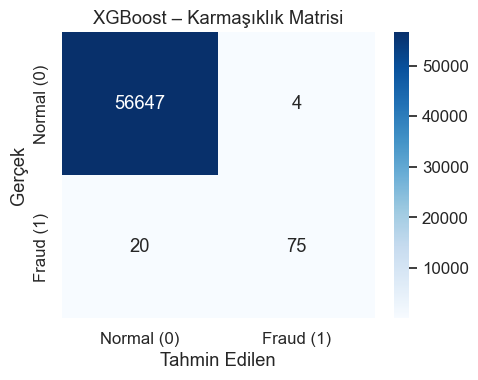

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal (0)", "Fraud (1)"],
    yticklabels=["Normal (0)", "Fraud (1)"]
)
plt.title("XGBoost – Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss",
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

os.makedirs("outputs/figures", exist_ok=True)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/figures/xgboost_confusion.png", dpi=300)
plt.close()


fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}", color="green")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/figures/xgboost_roc.png", dpi=300)
plt.close()


precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost - Precision-Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures/xgboost_pr.png", dpi=300)
plt.close()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.99      0.74      0.84        95

    accuracy                           1.00     56746
   macro avg       0.99      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



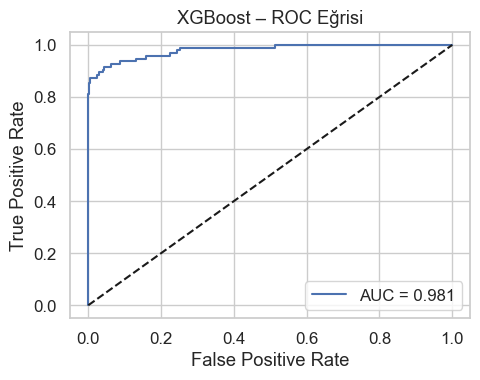

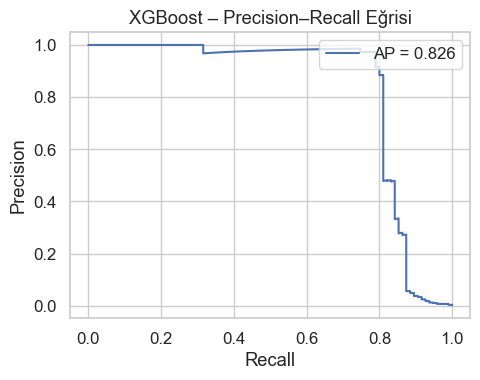

In [10]:
# ROC eğrisi
fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost – ROC Eğrisi")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall eğrisi
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost – Precision–Recall Eğrisi")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [11]:
import json

reports_dir = BASE / "outputs" / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

cls_report = classification_report(y_test, y_pred, output_dict=True)

metrics = {
    "model_name": "xgboost_model",
    "roc_auc": roc_auc,
    "average_precision": avg_prec,
    "classification_report": cls_report
}

out_json = reports_dir / "xgboost_metrics.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4, ensure_ascii=False)

print("XGBoost metrikleri kaydedildi →", out_json)


XGBoost metrikleri kaydedildi → C:\Users\Administrator\Desktop\fraud-detection-win-ar\outputs\reports\xgboost_metrics.json


In [12]:
import numpy as np
import os

os.makedirs("outputs/reports", exist_ok=True)

np.save("outputs/reports/xgboost_y_test.npy", y_test)
np.save("outputs/reports/xgboost_y_pred.npy", y_pred)
np.save("outputs/reports/xgboost_y_prob.npy", y_prob)

print("XGBoost tahminleri kaydedildi (outputs/reports/...).")


XGBoost tahminleri kaydedildi (outputs/reports/...).
